## Imports

In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models

import torch.optim as optim
import torchvision.transforms as transforms
# from torch.utils.tensorboard import SummaryWriter

from utils import save_checkpoint, load_checkpoint, print_examples

from get_loader import get_loader

# To automatically reload the external files 
# (after update)
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt 

## Download Dataset

**Make text file suitable to CSV**

In [2]:
# for Clean 1 Sentences
# f_in = "../Data/flickr8k/Clean-1Sentences.txt"
# f_out = "../Data/flickr8k/Clean-1Sentences_withComma.txt"

# for Clean 5 sentences
# f_in = "../Data/flickr8k/Clean-5Sentences.txt"
# f_out = "../Data/flickr8k/Clean-5Sentences_withComma.txt"

# with open(f_in, 'r') as fin: 
#     with open(f_out, 'w') as fout: 
#         for line in fin: 
#             line = line.replace(',', '')    # change all commas to spaces
#             fout.write(",".join(line.split(" ", 1)))   # change first space to comma

# add the keys also (image,caption) manually

## Define Encoder and Decoder

**Encoder for Image features**

In [2]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        
        self.train_CNN = train_CNN    # whether train or not
        
        # pretrained inception model
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        
        # set dropout and relu layers
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
    def forward(self, images):
        # find features of images using inception model
        features = self.inception(images)
        
        for name, param in self.inception.named_parameters(): 
            # fully connected weight or bias
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            
            else:
                param.requires_grad = self.train_CNN
        
        # return the value associated
        return self.dropout(self.relu(features)) 

**Decoder for Captions**

In [3]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim = 0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        
        return outputs

## Define Model

In [4]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
    
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)
    
    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs
    
    def caption_image(self, image, vocabulary, max_length = 50):
        result_caption = []
        
        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None
            
            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                
                predicted = output.argmax(1)
                
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)
                
                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break
        
        return [vocabulary.itos[idx] for idx in result_caption]

## Training Model

**Transformer**

In [5]:
transform = transforms.Compose(
[
    transforms.Resize((356, 356)),
    transforms.RandomCrop((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

**Get Dataset and train loader**

In [6]:
train_loader, dataset = get_loader(
#     root_folder = "../Data/flickr8k/images",
    root_folder = "../Data/test_examples/images/",
#     annotation_file = "../Data/flickr8k/captions.txt",
#     annotation_file = "../Data/flickr8k/Clean-1Sentences_withComma.txt",      # more fast and similar results to 5 sentences
#     annotation_file = "../Data/flickr8k/Clean-5Sentences_withComma.txt",
    annotation_file = "../Data/test_examples/captions_hindi.txt",
    transform = transform,
    num_workers = 2,
)

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = True

In [7]:
train_loader, dataset

(<torch.utils.data.dataloader.DataLoader at 0x7fc50d158be0>,
 <get_loader.FlickrDataset at 0x7fc50d144af0>)

In [18]:
for idx, (imgs, captions) in enumerate(train_loader):
        print(idx)
        print(imgs.shape)     # torch.size([32, 3, 224, 224])  like (batch_size, channels, h, w)
        print(captions.shape)   # torch.size([26, 32])  like (caption_length, batch_size)

0
torch.Size([2, 3, 299, 299])
torch.Size([10, 2])


#### conclusion - means train loader and dataset are perfectly correct.
because same in both cases, english and hindi captions.

**Define hyperparameters**

2258277193_586949ec62,मेट्रो के लिए इंतजार कर रहे लोग
2258277193_586949ec62,कुछ लोग बड़ी इमारत में खिड़कियां देख रहे थे।
2258277193_586949ec62,तीन लोग ट्रेन के प्लेटफार्म पर इंतजार कर रहे हैं।
2258277193_586949ec62,स्टेशन पर तीन लोग खड़े थे।
2258277193_586949ec62,ट्रेन की पटरियों के पास महिला और आदमी खड़े थे।

2258277193_586949ec62,मेट्रो के लिए इंतजार कर रहे लोग

In [7]:
# huperparameters
embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 5
learning_rate = 3e-4
num_epochs = 10

# for tensorboard
# writer = SummaryWriter("runs/flickr")     # creates the runs folder
step = 0

**Create Model and optimizer**

In [8]:
# Initialize model, loss, etc
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = dataset.vocab.stoi["<PAD>"])

optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [9]:
# BY SETTING THIS LOAD MODEL TO TRUE
# YOU CAN USE THE SAVED MODEL
# may be this will load the previous trained model
# load_model = True
# if load_model:
#     step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

=> Loading checkpoint


**Start Training**

Train with 1 clean sentence descriptions for 10 (might increase) epochs. 

In [29]:
model.train()

for epoch in range(num_epochs):
    print(epoch)
    # After each epoch, we will print some inferences 
#     print_examples(model, device, dataset)

    if save_model:
        checkpoint = {
            "state_dict" : model.state_dict(),
            "optimizer" : optimizer.state_dict(),
            "step" : step,
        }
        save_checkpoint(checkpoint)
    
    for idx, (imgs, captions) in enumerate(train_loader):
        imgs = imgs.to(device)
        captions = captions.to(device)
        
        outputs = model(imgs, captions[:-1])
        
        # (seq_len, N, vocabulary_size), (seq_len, N)
        loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
        
#         writer.add_scalar("Training loss", loss.item(), global_step = step)
        step += 1
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"loss for {epoch}: {loss}")

0
=> Saving checkpoint
loss for 0: 2.778986930847168
1
=> Saving checkpoint
loss for 1: 2.7755892276763916
2
=> Saving checkpoint
loss for 2: 2.7721219062805176
3
=> Saving checkpoint
loss for 3: 2.768561840057373
4
=> Saving checkpoint
loss for 4: 2.764906406402588
5
=> Saving checkpoint
loss for 5: 2.760763168334961
6
=> Saving checkpoint
loss for 6: 2.7561097145080566
7
=> Saving checkpoint
loss for 7: 2.7510621547698975
8
=> Saving checkpoint
loss for 8: 2.7449116706848145
9
=> Saving checkpoint
loss for 9: 2.737034559249878


**Result**

Result With Clean 5 sentence with comma :-

Taking tooooo much time (2 hour 0 epoch) and also gives similar results to 1 sentences.

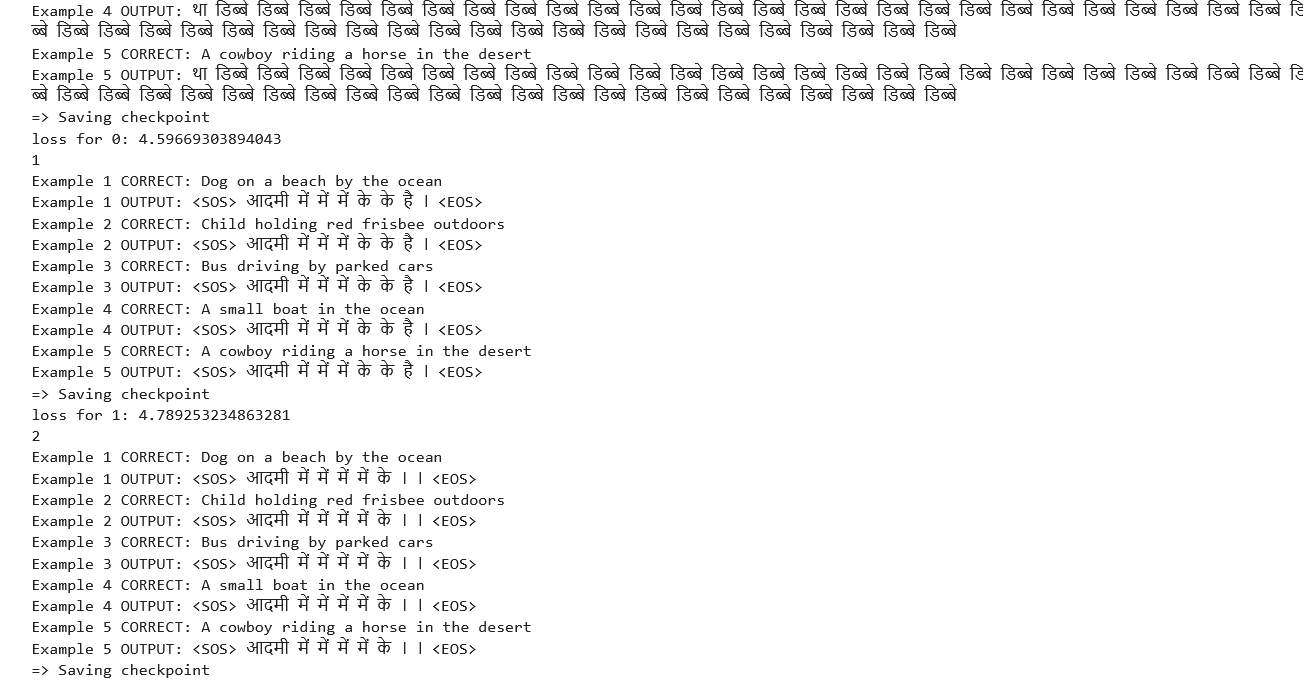

Result with Clean 1 sentences with comma :-

Not even close to get accepted.

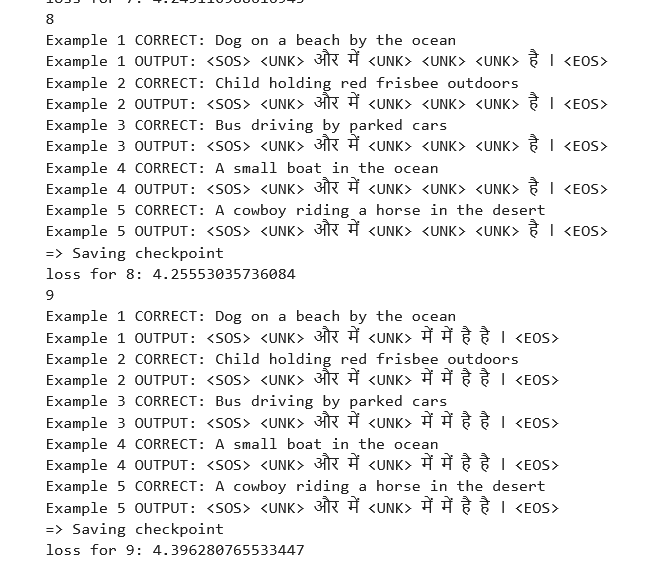


## Testing

Caption: पकड़े <EOS>


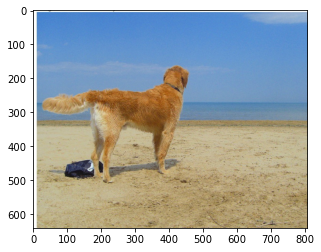

In [32]:
# read the iamge   (take car of png and jpg)
image_path = "../Data/test_examples/images/dog.jpg"   
img = Image.open(image_path)

plt.imshow(img)

# start evaluating
model.eval()

# transform image
img = transform(img.convert("RGB")).unsqueeze(0)

print("Caption: "+ " ".join(model.caption_image(img.to(device), dataset.vocab)))